# Machine Learning I
# Aprendizado Supervisionado
## Escrito por Duncan Ruiz

Prática com Decision Tree Classifier e velha

In [113]:
# pacotes básicos
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pacotes do sklearn para acesso a datasets, preparação, modelagem e avaliação
from sklearn import datasets
# pacote pipeline para combinar preparação e modelagem
from sklearn.pipeline import Pipeline, make_pipeline
# arsenal de preparação
from sklearn.preprocessing import MinMaxScaler # rescala em min-max
from sklearn.preprocessing import StandardScaler # padroniza features removendo média e
#     escalando para variância unitária. Também chamado de z-score
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold as skf
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import plot_tree, export_graphviz, export_text
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay as CMD
import sklearn.metrics as metrics

#pacotes para apoio a leitura e gravação de datasets
from pathlib import Path
import csv

#pacotes para visualização e formatação
import pprint
import graphviz

In [96]:
# carga de dados]
velha = pd.read_csv('amostras_.csv',sep = ';')

In [97]:
# separação em features e target
X = velha.drop(columns=['classe'])
y = velha['classe']

In [98]:
print(X.shape)
print(y.shape)

(750, 9)
(750,)


In [ ]:
# separação em treino e teste, e X e y

treino_X, teste_X, treino_y, teste_y = tts(X, y, random_state=0,test_size=0.1, stratify=y)
tr_X, v_X, tr_y, v_y = tts(treino_X, treino_y.to_numpy(), random_state=0,test_size=0.1, stratify=treino_y)

print(treino_X.shape)
print(treino_y.shape)
print(teste_X.shape)
print(teste_y.shape)
print(v_X.shape)
print(v_y.shape)
print(np.stack(np.unique(treino_y, return_counts=True), axis=1))
print(np.stack(np.unique(teste_y, return_counts=True), axis=1))
print(np.stack(np.unique(v_y, return_counts=True), axis=1))

(675, 9)
(675,)
(75, 9)
(75,)
(68, 9)
(68,)
[['Em_jogo' 225]
 ['Fim_de_jogo' 225]
 ['Possibilidade_de_fim_de_jogo' 225]]
[['Em_jogo' 25]
 ['Fim_de_jogo' 25]
 ['Possibilidade_de_fim_de_jogo' 25]]
[['Em_jogo' 23]
 ['Fim_de_jogo' 23]
 ['Possibilidade_de_fim_de_jogo' 22]]


In [100]:
teste_X

,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9
306,-1,1,-1,1,-1,0,0,0,1
732,-1,1,1,1,-1,-1,-1,1,1
562,0,1,-1,0,-1,1,1,-1,1
419,-1,1,-1,1,0,0,1,1,-1
139,1,-1,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...
25,1,-1,1,-1,1,1,0,-1,0
452,0,1,-1,0,1,-1,0,-1,1
585,-1,1,-1,-1,0,1,1,0,0
136,1,-1,1,1,-1,-1,0,-1,1


VALIDACAO CRUZADA

In [101]:
param_grid = {
        'criterion': ['log_loss','gini','entropy'],
        'min_samples_split': [2,3,4,5,6,7,8,9],
        'min_samples_leaf': [1,2,3,4,5],
        'class_weight': [None, 'balanced'],
        'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1]
    }

grid = gscv(
    DTC(),
    param_grid,
    n_jobs=-1,
    cv=10,         # 10-fold cross-validation
    scoring='accuracy'
)
grid.fit(tr_X, tr_y)
print("Melhores parametros:", grid.best_params_)
print("Acurácia média de validação:", grid.best_score_)

Melhores parametros: {'ccp_alpha': 0.005, 'class_weight': None, 'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 3}
Acurácia média de validação: 0.7098633879781421


VALIDACAO EXPLICITA

In [ ]:
# indução do modelo de classificação por árvore de decisão
#ccp_alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
ccp_alphas = [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1]
#ccp_alphas = [0.055]
#ccp_alphas = [0.0]
melhor_acc = 0
melhor_modelo = None
melhor_cm = None
for ccp_i in ccp_alphas:
    modelo = DTC(random_state=0
                ,criterion='log_loss'  # 'gini', 'entropy', 'log_loss'
                ,min_samples_split=3
                ,min_samples_leaf=1   # default 1
                ,max_leaf_nodes=None  # default None
                ,class_weight=None   # default None. 'balanced' para equilibrar classes
                ,ccp_alpha=ccp_i        # default 0.0 Valores na documentação 0.005 0.01 0.015 0.02 0.025 0.03 0.035
                )
    modelo.fit(tr_X, tr_y)
    v_pred_y = modelo.predict(v_X)
    acuracia = acc_score(v_y, v_pred_y)
    mat_cm = metrics.confusion_matrix(v_y, v_pred_y)
    if acuracia > melhor_acc:
        melhor_acc = acuracia
        melhor_modelo = modelo
        melhor_cm = mat_cm


    print('Alpha=', ccp_i,' Acuracia=', acuracia)


Alpha= 0.0  Acuracia= 0.7352941176470589
Alpha= 0.005  Acuracia= 0.7647058823529411
Alpha= 0.01  Acuracia= 0.7205882352941176
Alpha= 0.015  Acuracia= 0.6764705882352942
Alpha= 0.02  Acuracia= 0.6764705882352942
Alpha= 0.025  Acuracia= 0.6470588235294118
Alpha= 0.03  Acuracia= 0.6470588235294118
Alpha= 0.04  Acuracia= 0.6470588235294118
Alpha= 0.05  Acuracia= 0.6323529411764706
Alpha= 0.055  Acuracia= 0.6323529411764706
Alpha= 0.06  Acuracia= 0.6176470588235294
Alpha= 0.07  Acuracia= 0.6176470588235294
Alpha= 0.08  Acuracia= 0.6176470588235294
Alpha= 0.09  Acuracia= 0.5441176470588235
Alpha= 0.1  Acuracia= 0.5441176470588235


In [120]:
# apresentações do modelo
modelo_txt = export_text(modelo, feature_names=velha.drop(columns=['classe']).columns)
print(modelo_txt)

|--- pos3 <= -0.50
|   |--- class: Em_jogo
|--- pos3 >  -0.50
|   |--- pos2 <= 0.50
|   |   |--- class: Possibilidade_de_fim_de_jogo
|   |--- pos2 >  0.50
|   |   |--- class: Fim_de_jogo



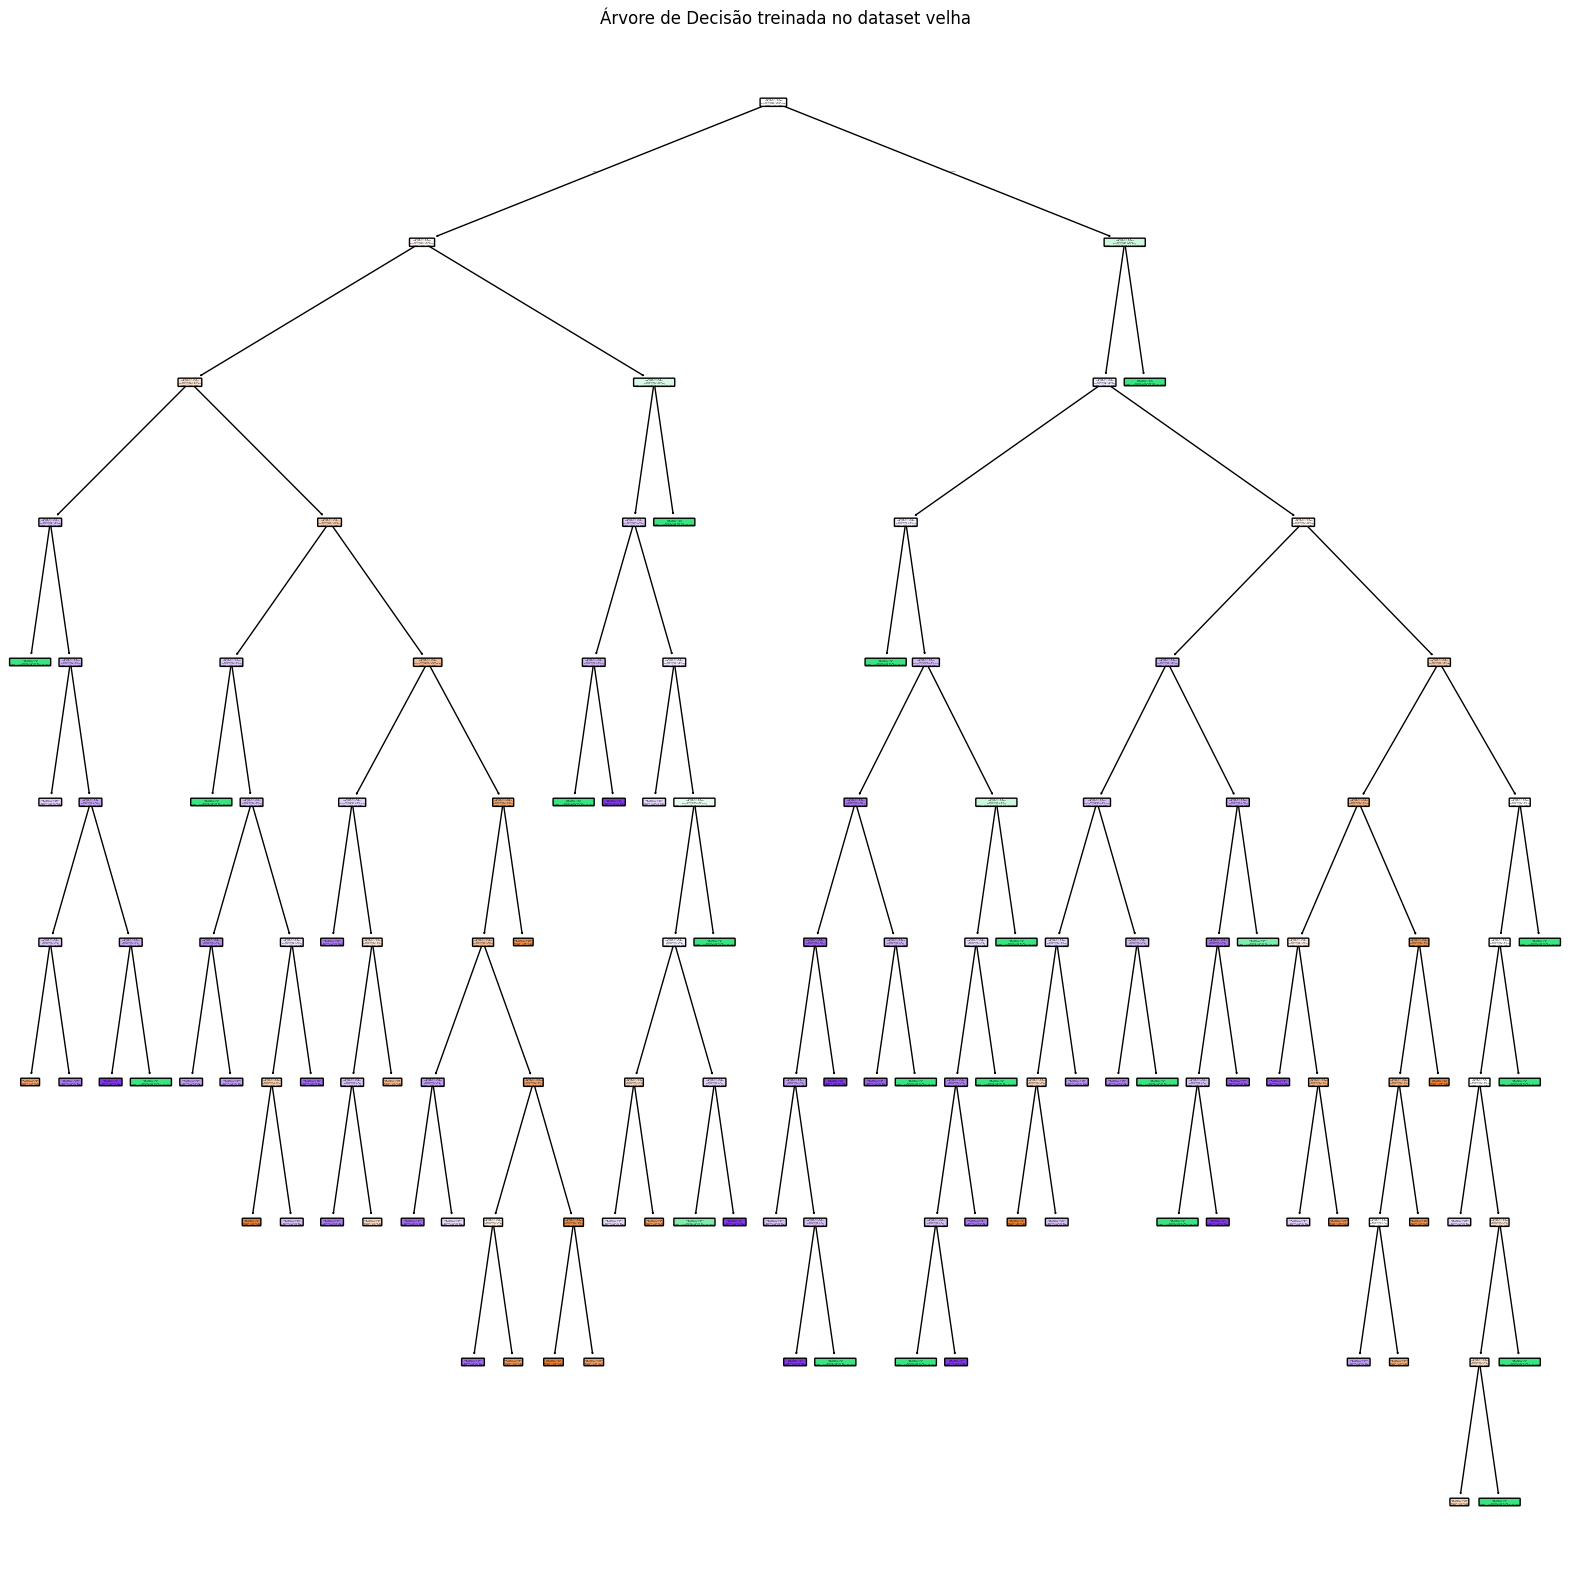

In [104]:
# apresentações do modelo
plt.figure(figsize=(20, 20))
plot_tree(modelo, filled=True, rounded=True, feature_names=velha.drop(columns=['classe']).columns, class_names=['Em_jogo','Possibilidade_de_fim_de_jogo','Fim_de_jogo'])
plt.title('Árvore de Decisão treinada no dataset velha')
plt.show()


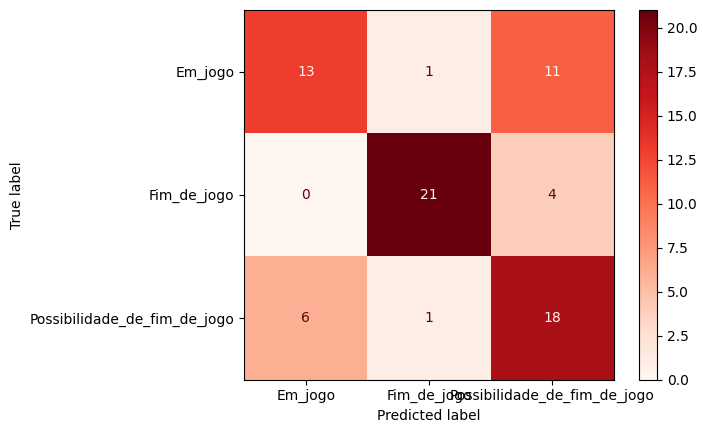

In [105]:
nomes_classes = velha.iloc[:, [9]].values
classes_unicas = np.unique(nomes_classes)
#print(classes_unicas)

cm = cm(teste_y, teste_pred_y)
disp = CMD(confusion_matrix=cm)
disp = CMD(confusion_matrix=cm, display_labels=classes_unicas)
disp.plot(cmap='Reds')